In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
# tsvファイルをcsvファイルに変更してから読み込み

In [2]:
df_train = pd.read_csv('train.csv', delimiter='\t')

In [3]:
df_train.head()

,id,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,3,1,1,female,35.0,1,0,53.1000,S
1,4,0,3,male,35.0,0,0,8.0500,S
2,7,0,3,male,2.0,3,1,21.0750,S
3,9,1,2,female,14.0,1,0,30.0708,C
4,11,1,1,female,58.0,0,0,26.5500,S


In [4]:
df_test = pd.read_csv('test.csv', delimiter='\t')

In [5]:
df_test.head()

,id,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,2,3,female,26.0,0,0,7.9250,S
3,5,3,male,NaN,0,0,8.4583,Q
4,6,1,male,54.0,0,0,51.8625,S


In [6]:
# 欠損値の確認
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id           0
survived     0
pclass       0
sex          0
age         85
sibsp        0
parch        0
fare         0
embarked     2
dtype: int64
id           0
pclass       0
sex          0
age         92
sibsp        0
parch        0
fare         0
embarked     0
dtype: int64


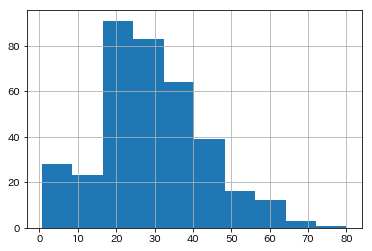

In [7]:
# 分布を確認
df_train['age'].hist()

In [8]:
print(df_train['age'].mean())
print(df_train['age'].median())
# 平均と中央値にはあまり違いはない

29.211583333333333
28.0


In [9]:
print(df_test['age'].mean())
print(df_test['age'].median())

30.194915254237287
28.25


In [10]:
df_train['age'] = df_train['age'].fillna(df_train['age'].median())
df_test['age']= df_test['age'].fillna(df_test['age'].median())

In [11]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id          0
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    2
dtype: int64
id          0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [12]:
# embarked毎のカウント数を確認
df_train['embarked'].value_counts()

S    325
C     79
Q     39
Name: embarked, dtype: int64

In [13]:
# Sが多いのでSを補完する
df_train['embarked'] = df_train['embarked'].fillna('S')

In [14]:
print(df_train.isnull().sum())

id          0
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [15]:
#Sの数が+2になっているかどうか確認
df_train['embarked'].value_counts()

S    327
C     79
Q     39
Name: embarked, dtype: int64

In [16]:
# survivedとの相関を見たいので文字列型のカラムをダミー変数に変換したい
# どのカラムが文字列型を確認
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 9 columns):
id          445 non-null int64
survived    445 non-null int64
pclass      445 non-null int64
sex         445 non-null object
age         445 non-null float64
sibsp       445 non-null int64
parch       445 non-null int64
fare        445 non-null float64
embarked    445 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 8 columns):
id          446 non-null int64
pclass      446 non-null int64
sex         446 non-null object
age         446 non-null float64
sibsp       446 non-null int64
parch       446 non-null int64
fare        446 non-null float64
embarked    446 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 28.0+ KB
None


In [17]:
# embarkedをダミー変数に変更する
# df_train["sex"] = pd.get_dummies(df_train[["sex"]])
df_train["embarked"] = pd.get_dummies(df_train["embarked"])
# df_test["sex"] = pd.get_dummies(df_test[["sex"]])
df_test["embarked"] = pd.get_dummies(df_test["embarked"])

In [18]:
print(df_train.head())
print(df_test.head())

   id  survived  pclass     sex   age  sibsp  parch     fare  embarked
0   3         1       1  female  35.0      1      0  53.1000         0
1   4         0       3    male  35.0      0      0   8.0500         0
2   7         0       3    male   2.0      3      1  21.0750         0
3   9         1       2  female  14.0      1      0  30.0708         1
4  11         1       1  female  58.0      0      0  26.5500         0
   id  pclass     sex    age  sibsp  parch     fare  embarked
0   0       3    male  22.00      1      0   7.2500         0
1   1       1  female  38.00      1      0  71.2833         1
2   2       3  female  26.00      0      0   7.9250         0
3   5       3    male  28.25      0      0   8.4583         0
4   6       1    male  54.00      0      0  51.8625         0


In [20]:
df_train['sex'] = df_train['sex'].replace('female', -1).replace('male', 1)
df_test['sex'] = df_test['sex'].replace('female', -1).replace('male', 1)

In [21]:
print(df_train.head())
print(df_test.head())

   id  survived  pclass  sex   age  sibsp  parch     fare  embarked
0   3         1       1   -1  35.0      1      0  53.1000         0
1   4         0       3    1  35.0      0      0   8.0500         0
2   7         0       3    1   2.0      3      1  21.0750         0
3   9         1       2   -1  14.0      1      0  30.0708         1
4  11         1       1   -1  58.0      0      0  26.5500         0
   id  pclass  sex    age  sibsp  parch     fare  embarked
0   0       3    1  22.00      1      0   7.2500         0
1   1       1   -1  38.00      1      0  71.2833         1
2   2       3   -1  26.00      0      0   7.9250         0
3   5       3    1  28.25      0      0   8.4583         0
4   6       1    1  54.00      0      0  51.8625         0


In [22]:
df_train['PS'] = df_train['pclass'] + df_train['sex']
df_test['PS'] = df_test['pclass'] + df_test['sex']

In [23]:
df_train['sex'] = df_train['sex'].replace(-1, 0).replace(1, 1)
df_test['sex'] = df_test['sex'].replace(-1, 0).replace(1, 1)

In [25]:
df_train['family'] = df_train['sibsp'] + df_train['parch']
df_test['family'] = df_test['sibsp'] + df_test['parch']

In [26]:
print(df_train.head())
print(df_test.head())

   id  survived  pclass  sex   age  sibsp  parch     fare  embarked  PS  \
0   3         1       1    0  35.0      1      0  53.1000         0   0   
1   4         0       3    1  35.0      0      0   8.0500         0   4   
2   7         0       3    1   2.0      3      1  21.0750         0   4   
3   9         1       2    0  14.0      1      0  30.0708         1   1   
4  11         1       1    0  58.0      0      0  26.5500         0   0   

   family  
0       1  
1       0  
2       4  
3       1  
4       0  
   id  pclass  sex    age  sibsp  parch     fare  embarked  PS  family
0   0       3    1  22.00      1      0   7.2500         0   4       1
1   1       1    0  38.00      1      0  71.2833         1   0       1
2   2       3    0  26.00      0      0   7.9250         0   2       0
3   5       3    1  28.25      0      0   8.4583         0   4       0
4   6       1    1  54.00      0      0  51.8625         0   2       0


In [27]:
df_train.corr()
# 今回はPSとの相関係数が大きいpclass、sexを除外する

,id,survived,pclass,sex,age,sibsp,parch,fare,embarked,PS,family
id,1.000000,0.024264,-0.059345,0.033435,0.105383,-0.020491,-0.031417,0.077649,-0.012297,-0.012677,-0.029503
survived,0.024264,1.000000,-0.358097,-0.559465,-0.069804,-0.045087,0.079669,0.258605,0.182568,-0.601734,0.007989
pclass,-0.059345,-0.358097,1.000000,0.193761,-0.280203,0.069857,-0.015726,-0.549651,-0.207779,0.736055,0.040397
sex,0.033435,-0.559465,0.193761,1.000000,0.063916,-0.097883,-0.220046,-0.168935,-0.102369,0.806712,-0.175216
age,0.105383,-0.069804,-0.280203,0.063916,1.000000,-0.187563,-0.140368,0.101165,0.003845,-0.124682,-0.197929
sibsp,-0.020491,-0.045087,0.069857,-0.097883,-0.187563,1.000000,0.423522,0.164773,-0.074573,-0.025460,0.896098
parch,-0.031417,0.079669,-0.015726,-0.220046,-0.140368,0.423522,1.000000,0.241855,-0.014436,-0.161304,0.781600
fare,0.077649,0.258605,-0.549651,-0.168935,0.101165,0.164773,0.241855,1.000000,0.219983,-0.447653,0.231961
embarked,-0.012297,0.182568,-0.207779,-0.102369,0.003845,-0.074573,-0.014436,0.219983,1.000000,-0.195792,-0.058423
PS,-0.012677,-0.601734,0.736055,0.806712,-0.124682,-0.025460,-0.161304,-0.447653,-0.195792,1.000000,-0.096565


In [ ]:
# ここからモデル作成

In [40]:
# survived、pclass、sex以外のすべての変数を特徴量にする
train_X = df_train.drop(['survived', 'pclass', 'sex'], axis=1)

In [41]:
# survivedを目的変数にする
train_y = df_train['survived']

In [42]:
train_data_set = lgb.Dataset(train_X, train_y)

In [43]:
params = {                                                                                               
    'boosting_type': 'gbdt',                                                                             
    'objective': 'regression_l2',                                                                           
    'metric': 'l2',                                                                             
    'num_leaves': 40,                                                                                    
    'learning_rate': 0.05,                                                                               
    'feature_fraction': 0.9,                                                                             
    'bagging_fraction': 0.8,                                                                             
    'bagging_freq': 5,   
    'lambda_l2': 2,
} 

In [44]:
# http://www.mizugarasu.jp/
gbm = lgb.train(params, train_data_set, num_boost_round=1500)

In [45]:
test_X = df_test.drop(['pclass', 'sex'], axis=1)

In [46]:
# https://orizuru.io/blog/machine-learning/lightgbm-01/
# http://marugari2.hatenablog.jp/entry/2016/12/14/235747
pred_y = gbm.predict(test_X, num_iteration=gbm.best_iteration)

In [47]:
output = pd.read_csv('test.csv', delimiter='\t')

In [48]:
output['survived'] = pred_y

In [49]:
# survivedカラムが追加されているか確認
output.head()

,id,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,0,3,male,22.0,1,0,7.2500,S,0.222465
1,1,1,female,38.0,1,0,71.2833,C,0.953648
2,2,3,female,26.0,0,0,7.9250,S,0.806509
3,5,3,male,NaN,0,0,8.4583,Q,0.099822
4,6,1,male,54.0,0,0,51.8625,S,0.395577


In [50]:
# いったんcsvファイルで保存
# その後、http://cgikon.com/tools/chfile/chfile_1.htmlでtsvファイルに変換
output[['id', 'survived']].to_csv('sample_submit_180919_2.csv', header=False, index= False)

In [ ]:
# 結果は0.813674694877409